In [1]:
import os
import re
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict, Counter
from pybedtools import BedTool

In [2]:
promoters = pd.read_csv("/gale/netapp/DoD/wenliang/projects/10.BrainEvolution/01.methylation/00.MCDS/02.promoter/01.Human/promoter.bed.gz",
                        sep="\t", names=['chrom', 'start','end', 'Tid'])
genes = pd.read_csv("/gale/netapp/DoD/wenliang/database/ref/hg38/Annotation/gencode.v35.annotation.gene.slop2K.bed.gz", 
                   sep="\t", names=['chrom', 'start', 'end', 'GeneID'])

In [3]:
promoters = promoters[promoters['start']>0]
genes = genes[genes['start']>0]

In [4]:
dmr_files = glob.glob("../*CG_DMRbed/*.bed")

In [5]:
dmr_annotation = defaultdict(Counter)
for dmrfile in dmr_files:
    celltype = re.sub(".bed", "", os.path.basename(dmrfile))
    dmr_bed = BedTool(dmrfile)
    
    intersect_promoter = dmr_bed.intersect(BedTool.from_dataframe(promoters), wao=True)
    intersect_promoter_df = intersect_promoter.to_dataframe(names=['chrom1', 'start1', 'end1', 'chrom2','start2', 'end2',
                                                                   'Tid', 'overlap'])
    for i, row in intersect_promoter_df.iterrows():
        if row.overlap > 0:
            dmr_annotation[celltype]['Promoter'] += 1
    
    nonPromoter_dmrs = intersect_promoter_df.loc[intersect_promoter_df['overlap']==0, ['chrom1', 'start1', 'end1']]
    nonPromoter_dmrs_bed = BedTool.from_dataframe(nonPromoter_dmrs)
    intersect_gene = nonPromoter_dmrs_bed.intersect(BedTool.from_dataframe(genes), wao=True)
    intersect_gene_df = intersect_gene.to_dataframe(names=['chrom1', 'start1', 'end1', 'chrom2','start2', 'end2',
                                                                   'GeneID', 'overlap'])
    for i, row in intersect_gene_df.iterrows():
        if row.overlap > 0:
            dmr_annotation[celltype]['Intragenic'] += 1
        if row.overlap == 0:
            dmr_annotation[celltype]['Intergenic'] += 1

In [16]:
dmr_annotation_df = pd.DataFrame.from_dict(dmr_annotation)

In [23]:
cell_order = ['B-Mem','B-Naive', 'Monocyte','NK-cell1', 'NK-cell2', 'Th-Mem','Th-Naive','Tc-Naive', 'Tc-Mem']

In [26]:
import matplotlib

In [27]:
matplotlib.rc('pdf', fonttype=42)

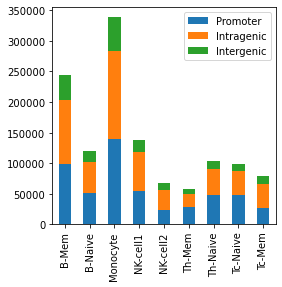

In [28]:
fig, ax = plt.subplots(1,1, figsize=(4, 4))
dmr_annotation_df.loc[cell_order].plot(kind='bar', stacked=True, ax=ax)
plt.savefig("DMR_annotation.pdf")

In [13]:
dmr_annotation_melt

,Region,cell_type,Count
0,Promoter,B-Mem,99261
1,Intragenic,B-Mem,103559
2,Intergenic,B-Mem,41804
3,Promoter,NK-cell2,23721
4,Intragenic,NK-cell2,32260
5,Intergenic,NK-cell2,11472
6,Promoter,Tc-Mem,27309
7,Intragenic,Tc-Mem,38591
8,Intergenic,Tc-Mem,13135
9,Promoter,Th-Mem,27663


# gene enrichment